In [3]:
import numpy as np 
from numpy import unravel_index
#import warnings
#warnings.simplefilter('ignore')
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

from skimage.measure import compare_ssim as ssim


#Saliency based region extraction firsst frame

In [4]:
sal_path = "C:\\Users\\beula\\Documents\\datascience\\Project\\DHF1K\\annotation\\{:04d}\\maps\\{:04d}.png"
frame_path = "C:\\Users\\beula\\frame\\{:03d}\\frame{}.jpg"
video_path = "C:\\Users\\beula\\Documents\\datascience\\Project\\DHF1K\\video\\{:03d}.avi"
ouput_path = "C:\\Users\\beula\\frame\\crop\\{:03d}\\{:04d}.png"
video_out_path = "C:\\Users\\beula\\frame\\crop\\{:04d}.avi"
text_path = "C:\\Users\\beula\\frame\\crop\\{:04d}.txt"

salfile = sal_path.format(15,1)
framefile = frame_path.format(15,0)
print(framefile)

C:\Users\beula\frame\015\frame0.jpg


In [5]:
target_width = 400
target_height =  300
actual_width = 640
actual_height = 360

In [6]:
def sobel_edges(img):
    # Sobel Operator
    h, w, d = img.shape

    # define filters
    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # s2
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # s1

    # define images with 0s
    newgradientImage = np.zeros((h, w, d))

    # offset by 1
    for channel in range(d):
        for i in range(1, h - 1):
            for j in range(1, w - 1):
                horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1, channel]) + \
                             (horizontal[0, 1] * img[i - 1, j, channel]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1, channel]) + \
                             (horizontal[1, 0] * img[i, j - 1, channel]) + \
                             (horizontal[1, 1] * img[i, j, channel]) + \
                             (horizontal[1, 2] * img[i, j + 1, channel]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1, channel]) + \
                             (horizontal[2, 1] * img[i + 1, j, channel]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1, channel])

                verticalGrad = (vertical[0, 0] * img[i - 1, j - 1, channel]) + \
                           (vertical[0, 1] * img[i - 1, j, channel]) + \
                           (vertical[0, 2] * img[i - 1, j + 1, channel]) + \
                           (vertical[1, 0] * img[i, j - 1, channel]) + \
                           (vertical[1, 1] * img[i, j, channel]) + \
                           (vertical[1, 2] * img[i, j + 1, channel]) + \
                           (vertical[2, 0] * img[i + 1, j - 1, channel]) + \
                           (vertical[2, 1] * img[i + 1, j, channel]) + \
                           (vertical[2, 2] * img[i + 1, j + 1, channel])

                # Edge Magnitude
                mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
                # Avoid underflow: clip result
                if(mag > 30):
                  newgradientImage[i - 1, j - 1, channel] = mag

    # now add the images r g and b
    rgb_edge = newgradientImage[:,:,0] + newgradientImage[:,:,1] + newgradientImage[:,:,2]
    return rgb_edge

In [7]:
def crop_image(img,point, h, w):
    return img[point[0]:point[0] +h , point[1]:point[1] +w ]


def search_combo(edge_map , sal_map, tot_sal,total_edge, thresh = 80):
    search_h , search_w = edge_map.shape
    found = False
    
    for i in range(search_h):
        for j in range(search_w):
            sal_percent = (sal_map[i][j] / tot_sal) * 100
            edge_percent = (edge_map[i][j] / total_edge) * 100
            #print(sal_percent)
            #print(edge_percent)
            if sal_percent >= thresh and edge_percent >= thresh:
                found = True
                break
                
    return i,j, found

def scan_image_sal_edge_max_val(sal_img,edge_img, match_h, match_w):
   h,w =  sal_img.shape
   sal_max = np.zeros((h - match_h + 1, w - match_w + 1))
   edge_max = np.zeros((h - match_h + 1, w - match_w + 1))
   search_h, search_w =   sal_max.shape 
   print("Search dimension {} {}".format(search_h, search_w))
   
   for i in range(search_h):
        for j in range(search_w):
            sal_max[i][j] = sal_img[i:i+match_h, j :j + match_w].sum()
            edge_max[i][j] = edge_img[i:i+match_h, j :j + match_w].sum()
            

   return sal_max, edge_max


def scan_image_sal_match_val(full_img, search_image,sal_img):
   h,w, _ =  full_img.shape
   match_h, match_w, _ = search_image.shape
   match_max = np.zeros((h - match_h + 1, w - match_w + 1))
   sal_max = np.zeros((h - match_h + 1, w - match_w + 1)) 
   search_h, search_w =   match_max.shape 
   print("Search dimension {}, {}".format(search_h, search_w))
    
   for i in range(search_h):
        for j in range(search_w):
            match_max[i][j] = ssim(full_img[i:i+match_h, j :j + match_w], search_image,multichannel = True)
            sal_max[i][j] = sal_img[i:i+match_h, j :j + match_w].sum()
            
   point = unravel_index(sal_min.argmax(), sal_min.shape)
   print(point)
   return sal_max, match_max
               

In [8]:
def First_Frame(frame , sal_img):



    #print("file {}".format(file_no))
    
    img_edge = sobel_edges(frame)
    sal_max, edge_max = scan_image_sal_edge_max_val(sal_img, img_edge,target_height, target_width )
    
    tot_sal = sal_img.sum()
    total_edge = img_edge.sum()
    sal_point = unravel_index(sal_max.argmax(), sal_max.shape)
    info_in_image = (np.count_nonzero(img_edge) / (img_edge.shape[0] * img_edge.shape[1])) * 100
    
    #print(sal_point)
    
    edge_point = unravel_index(edge_max.argmax(), sal_max.shape)
    #print(edge_point)
    
    edge_sal = sal_img[edge_point[0]:edge_point[0] +target_height , edge_point[1]:edge_point[1] +target_width ].sum()
    percent = int((edge_sal/tot_sal) * 100)
    
    
    #print(np.count_nonzero(img_edge) / (img_edge.shape[0] * img_edge.shape[1] ))
    #print("sal percent {}".format(percent))
    point = [sal_point[0], sal_point[1]]
    
    #if there is too much info then choose saliency
    if(percent >= 80 and info_in_image < 50):
       point = [edge_point[0], edge_point[1]]
       print("Choose sparse info")

    return point

In [9]:
def Track_frame(full_img, sal_img,search_frame, search_area) :
    lower_bound_h = search_area[0] - 20
    upper_bound_h = search_area[0] + 20
    lower_bound_w = search_area[1] - 20
    upper_bound_w = search_area[1] + 20  
    
    #target_h , target_w = search_frame.shape
    #actual_h, actual_w = full_img.shape
    tot_sal = sal_img.sum()
    search_h = actual_height - target_height + 1
    search_w = actual_width - target_width + 1
    

    
    if lower_bound_h < 0:
        lower_bound_h = 0
    if lower_bound_w < 0:
        lower_bound_w = 0
        
    if upper_bound_h > search_h:
        upper_bound_h = search_h
    if upper_bound_w > search_w:
        upper_bound_w = search_w

    #print("height search {} , {}".format(lower_bound_h, upper_bound_h))
    #print("width search {} , {}".format(lower_bound_w, upper_bound_w)) 
    #print("Search dimension {}, {}".format(search_h, search_w))
    #print("add search_frame {} ".format(id(search_frame)))
    #print("add full_img {} ".format(id(full_img)))
    
    max_match = np.zeros((search_h , search_w))
    sal_max = np.zeros((search_h , search_w))
    
    for i in range(lower_bound_h, upper_bound_h):
        for j in range(lower_bound_w, upper_bound_w):
            #extract_img = .copy()
            max_match[i][j] = ssim(full_img[i:i+target_height, j :j + target_width], search_frame,multichannel = True)
            #extract_img = .copy()
            sal_max[i][j] = sal_img[i:i+target_height, j :j + target_width].sum()
            
    sal_point = unravel_index(sal_max.argmax(), sal_max.shape)   
    match_point = unravel_index(max_match.argmax(), max_match.shape)
    
    point = [match_point[0], match_point[1]]
    #print("match point {}".format(point))
    #match_sal_img = sal_img[point[0]:point[0] +target_height , point[1]:point[1] +target_width ]
    match_sal = sal_max[point[0], point[1]]      
    percent = int((match_sal/tot_sal) * 100) 
    
    if(max_match[match_point[0]][match_point[1]] < 0.5):
        print("Performing full search")  
        #print("Max ssim got so far {}".format(max_match[point[0]][point[1]]))
        for i in range(search_h):
           for j in range(search_w):
              #extract_img = .copy()
              max_match[i][j] = ssim(full_img[i:i+target_height, j :j + target_width], search_frame,multichannel = True)
              #extract_img = sal_img[i:i+target_height, j :j + target_width].copy()
              sal_max[i][j] = sal_img[i:i+target_height, j :j + target_width].sum()
            
        sal_point = unravel_index(sal_max.argmax(), sal_max.shape)   
        match_point = unravel_index(max_match.argmax(), max_match.shape)
        #print("match point {}".format(point))
        point = [match_point[0], match_point[1]]
        #match_sal_img = sal_img[point[0]:point[0] +target_height , point[1]:point[1] +target_width ].copy()
        match_sal = sal_max[point[0], point[1]]       
        percent = int((match_sal/tot_sal) * 100) 
    else:

      if(percent <= 60):
        print("Sal max")
        if (sal_point[0] - match_point[0]  > 2):
            point[0] = point[0] + 2
        elif (sal_point[0] - match_point[0] < -2):
            point[0] = point[0] - 2
        else:
            point[0] = sal_point[0]
            
        if (sal_point[1] - match_point[1] > 2):
            point[1] = point[1] + 2
        elif (sal_point[1] - match_point[1] < -2):
            point[1] = point[1] - 2    
        else:
            point[1] = sal_point[1]
    

    
    #crop_image(sal_img,match_point, target_height,target_width).sum()
    #percent = int((match_sal/tot_sal) * 100)  
    print("percentage sal{}".format(percent))
    print("Max ssim {}".format(max_match[point[0]][point[1]]))
    
    return point
    

In [16]:

def crop_video(file_no):
    video_file = video_path.format(file_no)
    cap = cv2.VideoCapture(video_file)
    frame_count = 1
    prev_img =  []
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(file_no)
    video_file = video_out_path.format(file_no)
    text_file = text_path.format(file_no)
    text_out = open(text_file,'w')
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(video_file)
    out = cv2.VideoWriter(video_file, fourcc, fps, (target_width,target_height))
    
    ret, frame = cap.read()
    
    while(ret == True):
         
         sal_file = sal_path.format(file_no,frame_count)
         sal_img = cv2.imread(sal_file, 0)
         #print(sal_file)
         text_str = "{}   {} \n"
            
         if (frame_count != 1):
           ssim_val = ssim(frame, prev_img, multichannel = True)        
           #print("Similarity between images {}".format(ssim_val))
            
         if (frame_count == 1 or  ssim_val < 0.3):
           print("New search")
           search_area = First_Frame(frame, sal_img)  
           text_in = text_str.format(search_area[0], search_area[1])
           print("frame point {} \n".format(search_area))
         else:
           
           search_area = Track_frame(frame, sal_img, search_frame, search_area) 
           text_in = text_str.format(search_area[0], search_area[1])
           print("frame point {} \n".format(search_area))
         
         #prev_img = np.array(frame)
         prev_img = frame.copy()
         
         search_frame = prev_img[search_area[0]:search_area[0] + target_height ,
                                search_area[1]:search_area[1] + target_width].copy() 
         
         #crop_image(frame, search_area, target_height, target_width)
       
         #print(frame_count)
         #print(ouput_path)
         text_out.write(text_in)
         print(text_in)
         #output_file = ouput_path.format(file_no, frame_count)
         #cv2.imwrite(output_file, search_frame)
         out.write(search_frame)
         #print("Writing output_file {}.".format(output_file)) 
         frame_count = frame_count + 1
         ret, frame = cap.read()
       
    cap.release()
    out.release()
    text_out.close()
    cv2.destroyAllWindows()
    return



In [19]:
#file_list = [1]


for file_no in range(20,21):
    print(file_no)
    crop_video(file_no)
    

20
20
C:\Users\beula\frame\crop\0020.avi
New search
Search dimension 61 241
frame point [0, 91] 

0   91 

percentage sal99
Max ssim 0.8162085508056363
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.7163076229751192
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.745033875484213
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.8478770006248016
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.7663988404652932
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.8773332784900654
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.7647912811656677
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.8742478963256956
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.80930001368489
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.8923698018929874
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.996026804184451
frame point [0, 91] 

0   91 

percentage sal100
Max ssim 0.7934936177685051
frame

KeyboardInterrupt: 

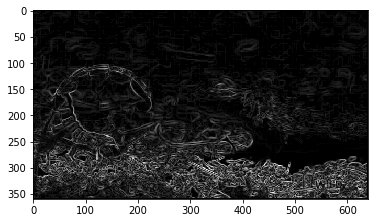

In [220]:
plt.imshow(img_edge, cmap='gray')
plt.show()

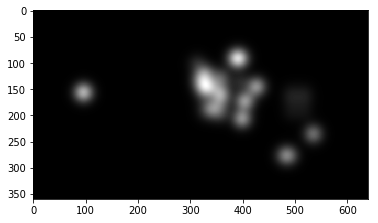

In [368]:
sal_file = sal_path.format(1,1)
sal_img = cv2.imread(sal_file, 0)
plt.imshow(sal_img, cmap='gray')
plt.show()